# Analysis of intervention measures

In [242]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from os.path import join
from os import listdir
import numpy as np
import seaborn as sns

import matplotlib
matplotlib.rc_file_defaults()

import warnings

warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


## Delta

### All students

In [243]:
src = "../../data/simulation_results/delta/ensembles_intervention_screening_delta_all"

results = pd.DataFrame()
for f in listdir(src):
    tmp = pd.read_csv(join(src, f))
    results = pd.concat([results, tmp])

results = results.reset_index(drop=True)
# subtract the index case
results["infected_agents"] = results["infected_agents"] - 1

# remove 100% occupancy and replace it with the "overbooked" setting,
# allowing as many students into lecture halls as enrolled
results = results[results["presence_fraction"] != 1.0]
results["presence_fraction"] = results["presence_fraction"].replace({"overbooked": 1.0})

results["occupancy"] = results["presence_fraction"].apply(
    lambda x: "{}%".format(int(x * 100)) if x != "overbooked" else "overbooked"
)


In [244]:
results["scenario"] = np.nan
results = results.set_index(["unistudent_mask", "lecturer_mask", "presence_fraction"])
results.loc[(0, 0, slice(None)), "scenario"] = "no masks"
results.loc[(1, 1, slice(None)), "scenario"] = "universal masks"
results.loc[(1, 0, slice(None)), "scenario"] = "masks students"
results.loc[(0, 1, slice(None)), "scenario"] = "masks faculty"
results = results.reset_index()


In [245]:
for scenario in ["no masks", "universal masks"]:
    for presence_fraction in [0.25, 0.5, 1.0]:
        subset = results[
            (results["scenario"] == scenario)
            & (results["presence_fraction"] == presence_fraction)
        ]
        print(
            "{} presence fraction {:1.0f}%: {:1.1f}% of index cases do not lead to an outbreak".format(
                scenario,
                presence_fraction * 100,
                len(subset[subset["infected_agents"] == 0]) / len(subset) * 100,
            )
        )


no masks presence fraction 25%: 71.2% of index cases do not lead to an outbreak
no masks presence fraction 50%: 61.7% of index cases do not lead to an outbreak
no masks presence fraction 100%: 52.5% of index cases do not lead to an outbreak
universal masks presence fraction 25%: 86.8% of index cases do not lead to an outbreak
universal masks presence fraction 50%: 80.1% of index cases do not lead to an outbreak
universal masks presence fraction 100%: 73.0% of index cases do not lead to an outbreak


In [246]:
results["scenario"] = np.nan
results = results.set_index(["unistudent_mask", "lecturer_mask", "presence_fraction"])
results.loc[(0, 0, 0.5), "scenario"] = "50% occupancy, no masks"
results.loc[(1, 1, 0.5), "scenario"] = "50% occupancy, masks"
results.loc[(1, 0, 0.5), "scenario"] = "50% occupancy, masks students"
results.loc[(0, 1, 0.5), "scenario"] = "50% occupancy, masks faculty"

results.loc[(0, 0, 1), "scenario"] = "100% occupancy, no masks"
results.loc[(1, 1, 1), "scenario"] = "100% occupancy, masks"
results.loc[(1, 0, 1), "scenario"] = "100% occupancy, masks students"
results.loc[(0, 1, 1), "scenario"] = "100% occupancy, masks faculty"
results = results.reset_index()


In [247]:
outbreaks = results[results["infected_agents"] > 0].copy()


### 80% vaccination coverage

#### Fig 1: Kernel density plot

<ipython-input-9-9298d14a7a1c>:18: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  g.axes[0][0].set_xlim(0, 1e4)


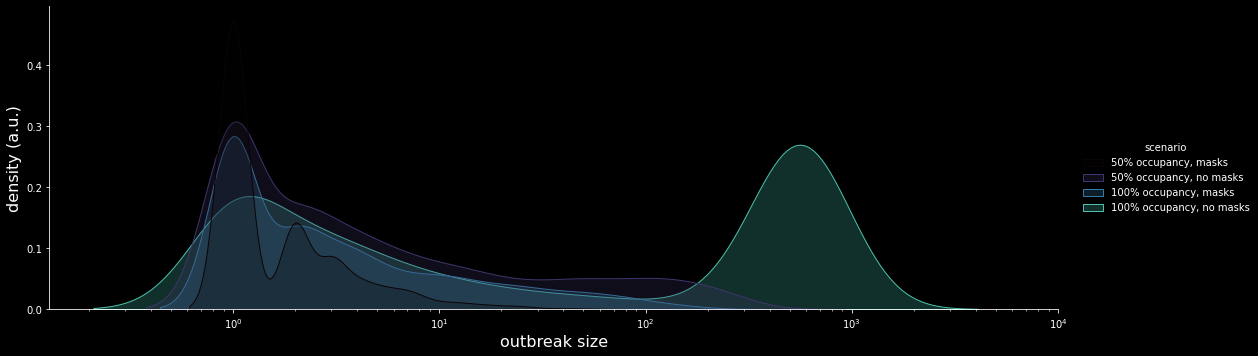

In [9]:
cmap = sns.color_palette("mako", as_cmap=True)
scenarios = [
    "100% occupancy, no masks",
    "100% occupancy, masks",
    "50% occupancy, no masks",
    "50% occupancy, masks",
]
scenarios.reverse()
colors = [cmap(0.75), cmap(0.5), cmap(0.25), cmap(0)]
colors.reverse()

vacc_ratio = 0.8
subset = outbreaks[
    (outbreaks["scenario"].isin(scenarios))
    & (outbreaks["presence_fraction"].isin([1, 0.5]))
    & (outbreaks["unistudent_vaccination_ratio"] == vacc_ratio)
]

g = sns.displot(
    subset,
    x="infected_agents",
    hue="scenario",
    kind="kde",
    fill=True,
    log_scale=True,
    height=5,
    aspect=3,
    hue_order=scenarios,
    palette=colors,
)

g.axes[0][0].set_xlim(0, 1e4)
g.set_axis_labels("outbreak size", "density (a.u.)", fontsize=16)
plt.savefig("../../plots/outbreak_sizes.svg")


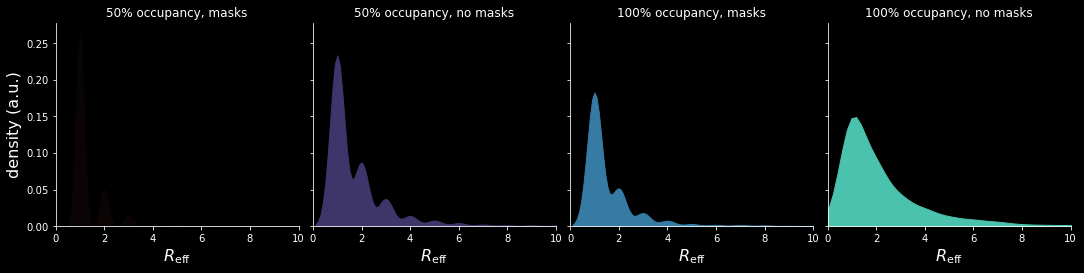

In [10]:
cmap = sns.color_palette("mako", as_cmap=True)
scenarios = [
    "100% occupancy, no masks",
    "100% occupancy, masks",
    "50% occupancy, no masks",
    "50% occupancy, masks",
]
scenarios.reverse()
colors = [cmap(0.75), cmap(0.5), cmap(0.25), cmap(0)]
colors.reverse()

vacc_ratio = 0.8
subset = outbreaks[
    (outbreaks["scenario"].isin(scenarios))
    & (outbreaks["presence_fraction"].isin([1, 0.5]))
    & (outbreaks["unistudent_vaccination_ratio"] == vacc_ratio)
]

g = sns.displot(
    subset,
    x="R0",
    col="scenario",
    kind="kde",
    fill=True,
    height=15 / 4,
    aspect=1,
    col_order=scenarios,
)

for i in range(len(scenarios)):
    g.axes[0][i].set_xlim(0, 10)
    g.axes[0][i].properties()["children"][0].set_color(colors[i])

    g.axes[0][i].set_title(scenarios[i])
g.set_axis_labels("$R_\\mathrm{eff}$", "density (a.u.)", fontsize=16)
plt.savefig("../../plots/R0.svg")


In [11]:
def print_stats(df, sm, lm, pf, vr, stat):
    """
    Parameters:
    -----------
    df: pandas DataFrame
        Simulation data of outbreaks
    sm: integer (0, 1)
        Student masks
    lm: integer (0, 1)
        Lecturer masks
    pf: float (0.25, 0.5, 1.0)
        Fraction of students present in lecture halls
    stat: string ('infected_agents' or 'RO')
        Observable for which statistics should be calculated
    """
    print("************* {} *************".format(stat))
    print(
        "student masks: {}, lecturer masks: {}, presence fraction: {}, vaccination ratio: {}".format(
            sm, lm, pf, vr
        )
    )
    print("mean {}: ".format(df.loc[sm, lm, pf, vr][stat].mean()))
    print(
        "95% credible interval: [{}; {}] ".format(
            df.loc[sm, lm, pf, vr][stat].quantile(0.025),
            df.loc[sm, lm, pf, vr][stat].quantile(0.975),
        )
    )
    print("maximum {}: ".format(df.loc[sm, lm, pf, vr][stat].max()))
    print("**************************")
    print()


#### Stats 80% vaccination

In [12]:
vacc_ratio = 0.8
subset = results[results["unistudent_vaccination_ratio"] == vacc_ratio]
subset = subset.set_index(
    [
        "unistudent_mask",
        "lecturer_mask",
        "presence_fraction",
        "unistudent_vaccination_ratio",
    ]
)


In [13]:
# 100 % occupancy
print("100% occupancy")
print_stats(subset, 0, 0, 1, 0.8, "R0")
print_stats(subset, 0, 0, 1, 0.8, "infected_agents")

# 100 % occupancy & masks
print("100% occupancy & masks")
print_stats(subset, 1, 1, 1, 0.8, "R0")
print_stats(subset, 1, 1, 1, 0.8, "infected_agents")

# 50 % occupancy
print("50% occupancy")
print_stats(subset, 0, 0, 0.5, 0.8, "R0")
print_stats(subset, 0, 0, 0.5, 0.8, "infected_agents")

# 50 % occupancy & masks
print("50% occupancy % masks")
print_stats(subset, 1, 1, 0.5, 0.8, "R0")
print_stats(subset, 1, 1, 0.5, 0.8, "infected_agents")


100% occupancy
************* R0 *************
student masks: 0, lecturer masks: 0, presence fraction: 1, vaccination ratio: 0.8
mean 1.0508: 
95% credible interval: [0.0; 6.0] 
maximum 36.0: 
**************************

************* infected_agents *************
student masks: 0, lecturer masks: 0, presence fraction: 1, vaccination ratio: 0.8
mean 110.0428: 
95% credible interval: [0.0; 674.0249999999996] 
maximum 858.0: 
**************************

100% occupancy & masks
************* R0 *************
student masks: 1, lecturer masks: 1, presence fraction: 1, vaccination ratio: 0.8
mean 0.3841: 
95% credible interval: [0.0; 3.0] 
maximum 17.0: 
**************************

************* infected_agents *************
student masks: 1, lecturer masks: 1, presence fraction: 1, vaccination ratio: 0.8
mean 2.1488: 
95% credible interval: [0.0; 22.0] 
maximum 211.0: 
**************************

50% occupancy
************* R0 *************
student masks: 0, lecturer masks: 0, presence fracti

#### Stats 70% vaccination

In [14]:
vacc_ratio = 0.7
subset = results[results["unistudent_vaccination_ratio"] == vacc_ratio]
subset = subset.set_index(
    [
        "unistudent_mask",
        "lecturer_mask",
        "presence_fraction",
        "unistudent_vaccination_ratio",
    ]
)


In [15]:
# 100 % occupancy
print("100% occupancy")
print_stats(subset, 0, 0, 1, 0.7, "R0")
print_stats(subset, 0, 0, 1, 0.7, "infected_agents")

# 100 % occupancy & masks
print("100% occupancy & masks")
print_stats(subset, 1, 1, 1, 0.7, "R0")
print_stats(subset, 1, 1, 1, 0.7, "infected_agents")

# 50 % occupancy
print("50% occupancy")
print_stats(subset, 0, 0, 0.5, 0.7, "R0")
print_stats(subset, 0, 0, 0.5, 0.7, "infected_agents")

# 50 % occupancy & masks
print("50% occupancy % masks")
print_stats(subset, 1, 1, 0.5, 0.7, "R0")
print_stats(subset, 1, 1, 0.5, 0.7, "infected_agents")


100% occupancy
************* R0 *************
student masks: 0, lecturer masks: 0, presence fraction: 1, vaccination ratio: 0.7
mean 1.5289: 
95% credible interval: [0.0; 9.0] 
maximum 64.0: 
**************************

************* infected_agents *************
student masks: 0, lecturer masks: 0, presence fraction: 1, vaccination ratio: 0.7
mean 450.9745: 
95% credible interval: [0.0; 1536.0249999999996] 
maximum 1742.0: 
**************************

100% occupancy & masks
************* R0 *************
student masks: 1, lecturer masks: 1, presence fraction: 1, vaccination ratio: 0.7
mean 0.5451: 
95% credible interval: [0.0; 4.0] 
maximum 20.0: 
**************************

************* infected_agents *************
student masks: 1, lecturer masks: 1, presence fraction: 1, vaccination ratio: 0.7
mean 16.3702: 
95% credible interval: [0.0; 267.02499999999964] 
maximum 543.0: 
**************************

50% occupancy
************* R0 *************
student masks: 0, lecturer masks: 0